In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Load domain shape (hotdog)

In [4]:
import sys
sys.path.append("../")
from scene import GaussianModel
target_gaussians = GaussianModel(3)
target_gaussians.optimizer = torch.optim.Adam([target_gaussians._xyz], lr=1e-1)
target_gaussians.active_sh_degree, target_gaussians._xyz, target_gaussians._features_dc, \
target_gaussians._features_rest, target_gaussians._scaling, target_gaussians._rotation, \
target_gaussians._opacity, target_gaussians.max_radii2D, \
_, _, _, target_gaussians.spatial_lr_scale = \
    torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_spheres/chkpnt30000.pth")[0]
    # torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog_spheres_v4/chkpnt30000.pth")[0]

    #torch.load("/home/dimakot55/output_data/gs_my/gs/new_scenes/GT_chair_spheres/chkpnt30000.pth")[0]
    # torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog_spheres/chkpnt30000.pth")[0]
    #torch.load("/home/dimakot55/output_data/gs/GT_hotdog_spheres_v1/chkpnt30000.pth")[0]
    

In [5]:

import torch
import torch.nn.functional as F
from scipy.spatial import distance
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def sample_points_by_density(points, num_samples=None, radius = 0.05, device='cuda'):
    """
    Samples points inversely proportional to their density in the neighborhood.
    :param points: torch tensor of shape [N,3]
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points.
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [num_samples] containing the indices of the sampled points
    """


    # Assuming you have a PyTorch tensor of shape [N, 3] representing points
    # Calculate pairwise distances between all points
    # Note that i only compute distance to every 10th neighbor.
    distances = torch.cdist(points, points[::10])


    # Calculate the number of points within the local region for each point
    num_points_in_local_region = (distances <= radius).sum(dim=1)

    # Calculate the inverse density as a weight
    inverse_density = 1.0 / (num_points_in_local_region + 1)  # Add 1 to avoid division by zero

    # Normalize the weights to create a probability distribution
    probability_distribution = inverse_density / inverse_density.sum()

    # Sample points inversely proportional to their density
    if num_samples is None:
        num_samples = len(points) // 10  # Adjust the number of samples as needed
    sampled_indices = torch.multinomial(probability_distribution, num_samples, replacement=True)

    return sampled_indices
    
def remove_outliers(points, kth_neighbor=30, q=0.925, device='cuda'):
    """
    Removes outliers from the given points. Usually the set of clusters must be small to avoid
    quadratic complexity of the all pairwise neighbors computation.
    :param points: torch tensor of shape [N, 3]
    :param kth_neighbor: this neighbor we use to approximate good neighborhood density.
    :param q: Quantile to use for removing outliers.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [N] containing the indices of the non-outlier points.
    """

    pairwise_distances = torch.cdist(points, points)
    kth_nearest_dists, kth_nearest_indices = torch.topk(pairwise_distances, k=kth_neighbor, dim=1, largest=False, sorted=True)
    q_outliers = torch.quantile(kth_nearest_dists[:, kth_neighbor-1], q=q)
    indcs_relevant = torch.where(kth_nearest_dists[:, kth_neighbor-1] < q_outliers)[0]
    return indcs_relevant

def prepare_scene(points, num_clusters=40, num_samples=None, radius=0.05, q=0.925, device='cuda'):
    """
    Prepares the scene by sampling points and clustering them.
    :param points: torch tensor of shape [N, 3]
    :param num_clusters: Number of clusters to use for KMeans clustering.
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points from EACH cluster
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A tuple containing the following tensors:
    """

     # Use KMeans clustering to find the centroids of the clusters
    kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=4)
    kmeans.fit(points.detach().cpu().numpy())
    clean_indices = []
    for lbls in np.unique(kmeans.labels_):
        cluster_points_idcs = np.where(kmeans.labels_ == lbls)[0]
        # Remove outliers
        non_outliers_idcs = remove_outliers(points[cluster_points_idcs], q=q, device=device)
        cluster_points_idcs = cluster_points_idcs[non_outliers_idcs.cpu().numpy()]
        # Sample points inversely proportional to the density
        sampled_idcs = sample_points_by_density(points[cluster_points_idcs], num_samples, radius, device)
        cluster_points_idcs = cluster_points_idcs[sampled_idcs.cpu().numpy()]
        clean_indices.append(cluster_points_idcs)

    return clean_indices, kmeans.cluster_centers_, kmeans.labels_[np.concatenate(clean_indices)]


In [6]:
target_shape_idcs, target_shape_cluster_centers, target_shape_cluster_labels = prepare_scene(
    points=target_gaussians._xyz,
    num_samples=None,
    radius=0.07,
    q=0.975, #0.975,
    num_clusters=80)


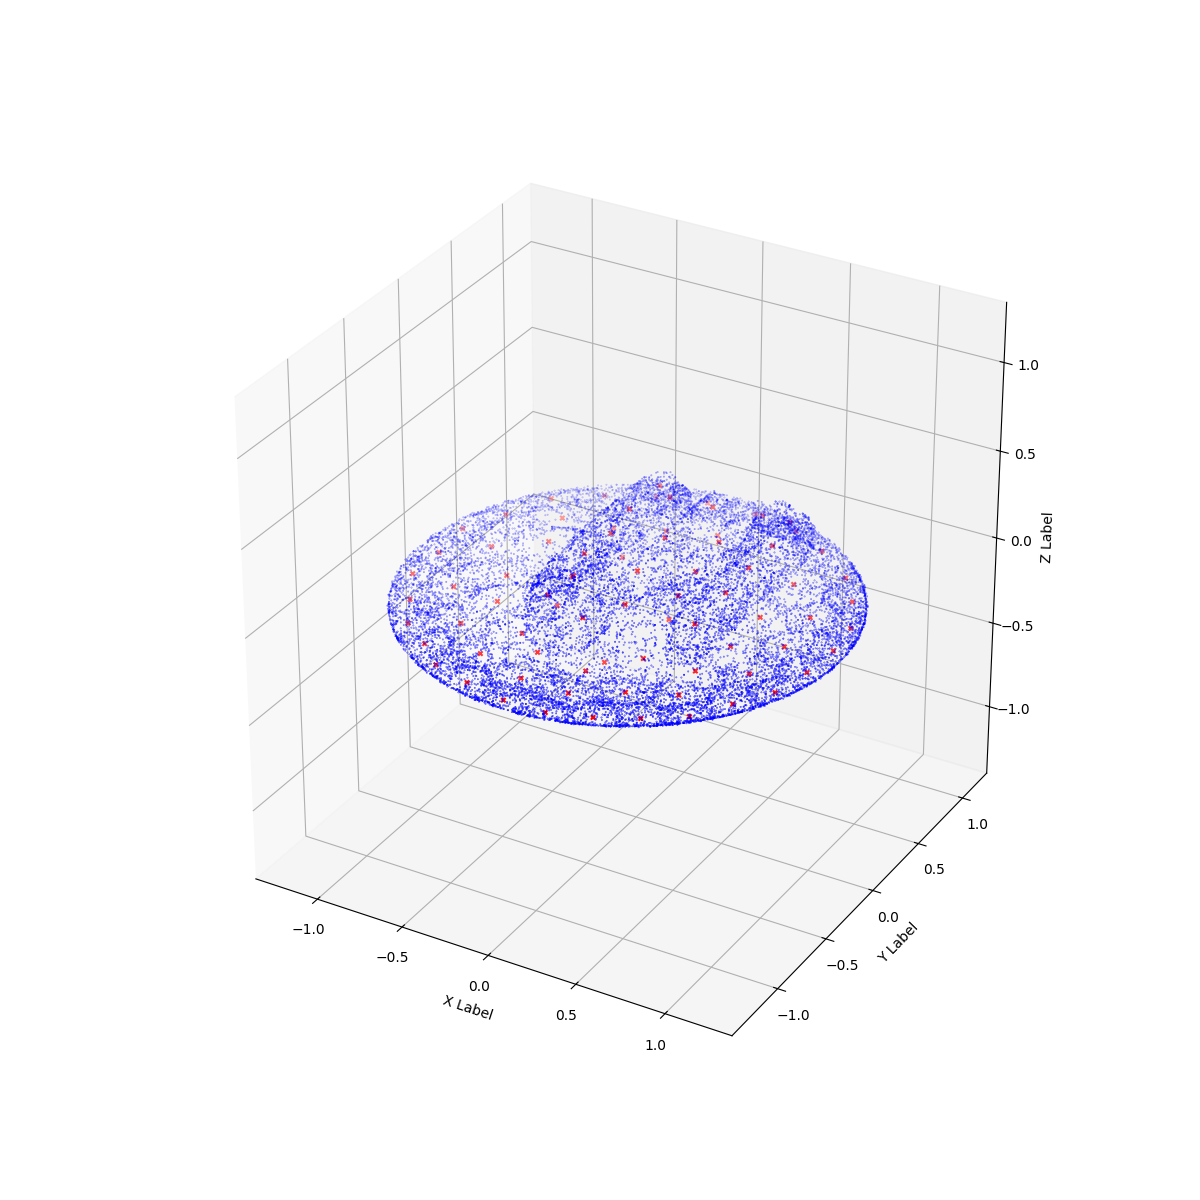

In [7]:

# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



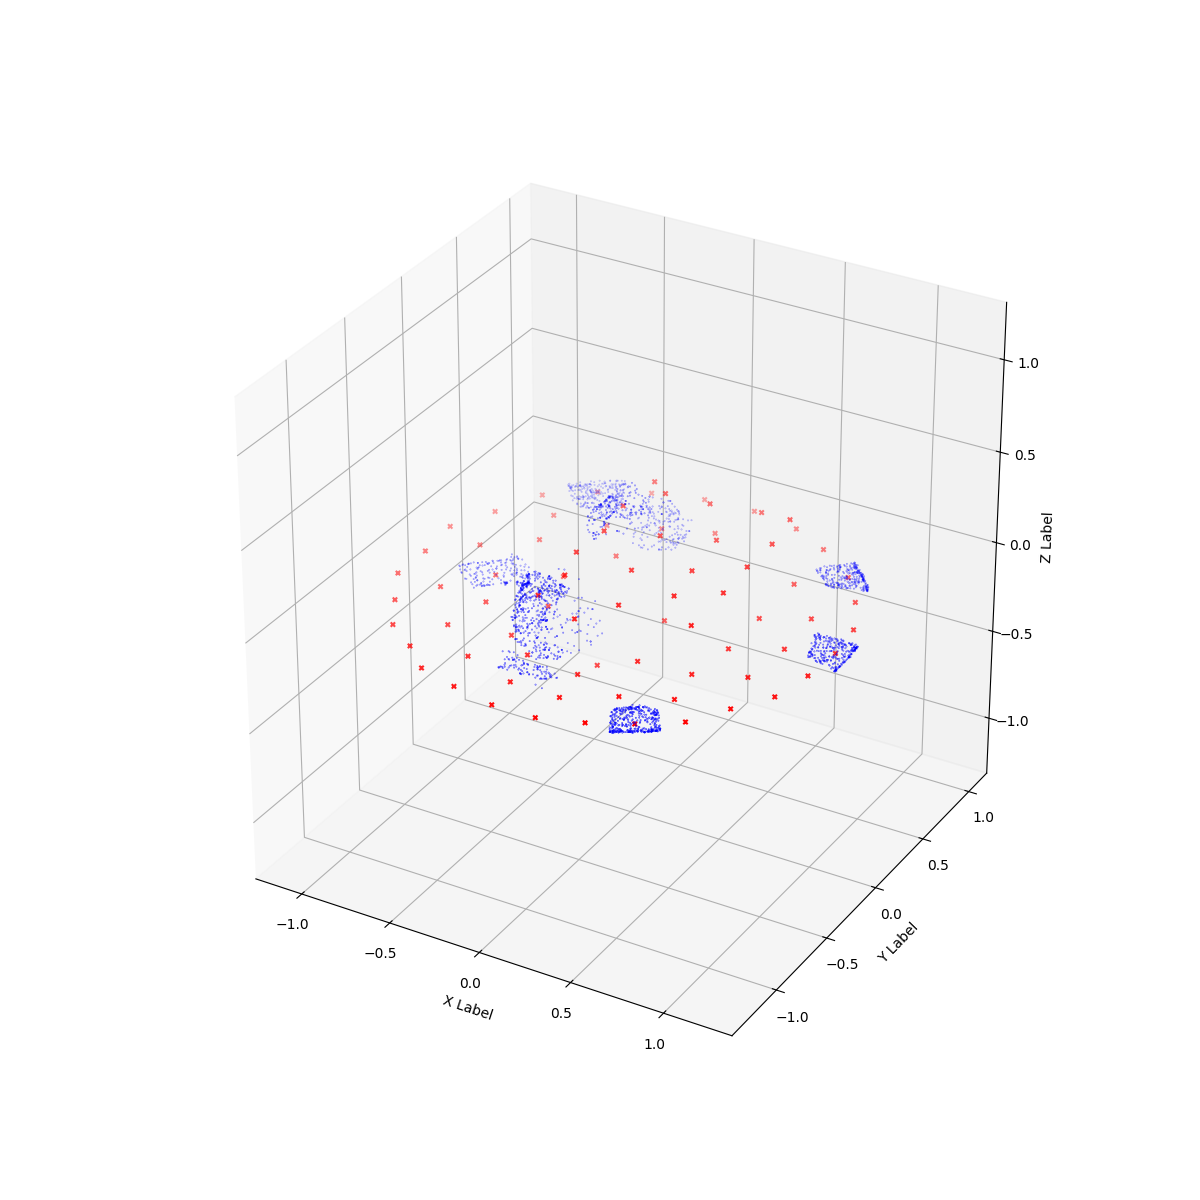

In [8]:

# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs[10:20], axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



# Load cluster patch from lego and visualize

In [9]:
loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 0. only for the bricks scene. Remove poitns underneath. and change size to smaller scale. Multiply coordinates and sizes.
idcs = np.where(gaussians_xyz[:,2]>-0.12)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]




# 1. Remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)


# Extra increase the volume of the points to make results more apparent
with torch.no_grad():
    # gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for lego
    gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for bricks 

FileNotFoundError: [Errno 2] No such file or directory: '/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz'

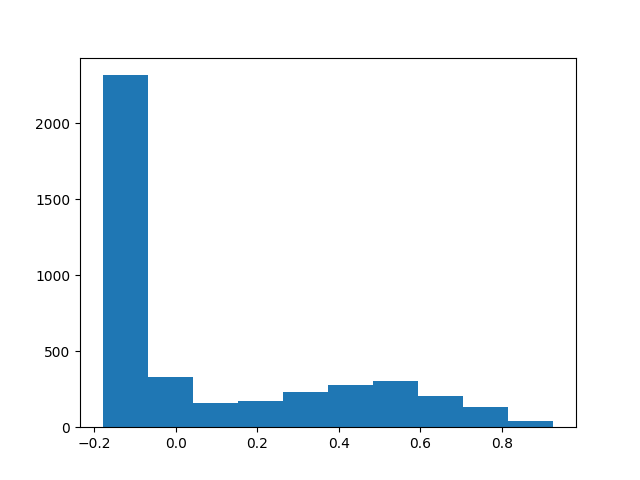

In [418]:
plt.figure()
plt.hist(gaussians_xyz[:,2])
plt.show()

In [419]:
gaussians_xyz

array([[-0.28377685,  0.18746132,  0.36353356],
       [-0.19820608, -0.15340546, -0.09588483],
       [-0.07347745,  0.15854329,  0.22183572],
       ...,
       [ 0.3841217 ,  0.28702363, -0.07305428],
       [ 0.114595  ,  0.20045958, -0.09219114],
       [-0.04113418,  0.2891091 , -0.15522797]], dtype=float32)

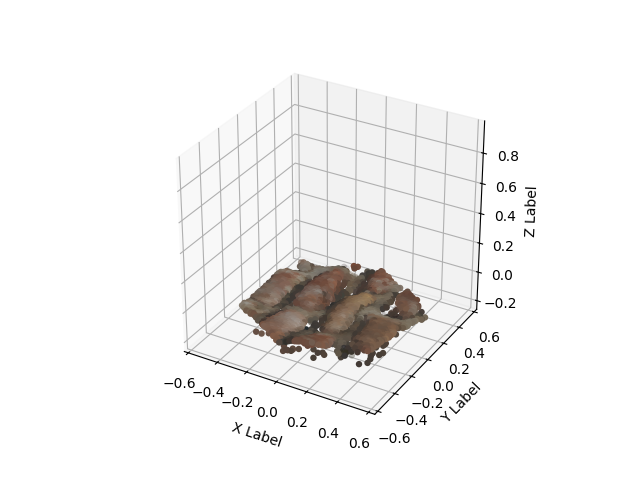

In [420]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2],#*1.5, 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()





[   0    1    2 ... 4162 4163 4164]


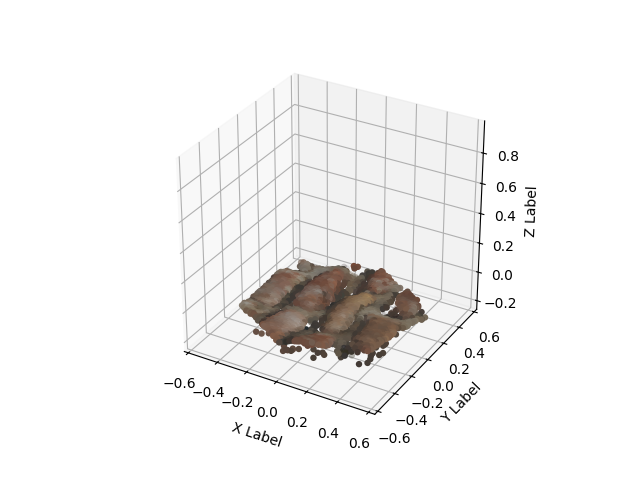

In [421]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
idcs = np.where(gaussians_xyz[:,2]>-0.25)[0]
print(idcs)
ax.scatter(gaussians_xyz[idcs,0], 
           gaussians_xyz[idcs,1], 
           gaussians_xyz[idcs,2],#*1.5, 
           c=np.concatenate([colors, alpha[:,None]], axis=-1)[idcs],# c='b', 
           marker='o',
           s=sizes[idcs], #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()





# Uniform coverage of the shape with a cluster
1. First we estimate the size of the style patch(cluster) we have at our disposal.
2. Then we find a coverage of the domain (hotdog scene) with ball of radius $r$.
   This value is a bit smaller then the value of the patch radius.
3. Now fit patches to each individual patch.
4. Merge them into a single scene.
5. Remove overlaps.
   

In [422]:
domain = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].clone()
# For bricks
domain = domain * 4.

In [423]:
domain.shape

torch.Size([19390, 3])

## First estimate the radius of the cluster

In [424]:
from scipy.spatial import distance
def get_cluster_radius(cluster_points):
    """
    Computes minimum and maximum of all the largest pairwise distances
    in the cluster. These correspond to the largest inner and largest outter circle.
    Main assumption is that the shape is connected. For flat surfaces use the 
    largest area and decrease it a bit. 
    :param cluster_points: Numpy array of shape [N,d]
    :return inner diameter and outer diameter 
    """

    pairwise_distances = distance.cdist(cluster_points, cluster_points)
    pairwise_max_distances = np.max(pairwise_distances, axis=1)
    outer_max_d = np.max(pairwise_max_distances)
    inner_max_d = np.min(pairwise_max_distances)
    return inner_max_d, outer_max_d

d_inter, d_outer = get_cluster_radius(gaussians_xyz)
print("Inter and outer radii of the style patch:", d_inter, d_outer)

Inter and outer radii of the style patch: 0.7410442522530434 1.4235711077808917


In [425]:
import numpy as np
from scipy.spatial import distance

def sample_circles(points, r, min_points_per_cluster=40):
    N, d = points.shape

    # Compute matrix of all pairwise distances
    pairwise_distances = distance.cdist(points, points)

    # Create a boolean array to track covered elements
    covered = np.zeros(N, dtype=bool)

    # List to store the indices of points in each circle
    circles = []

    while not all(covered):
        # Find the index of the next uncovered point
        query_point_idx = np.where(covered == 0)[0][0]
        points_indices_in_circle = []
        r_ = r
        while len(points_indices_in_circle) < min_points_per_cluster:
            points_indices_in_circle = np.where(pairwise_distances[query_point_idx] <= r_)[0]
            r_ = r_*2
        covered[points_indices_in_circle] = True
        # Add the current circle to the list
        circles.append(points_indices_in_circle)

    return circles

In [426]:
domain_circles = sample_circles(points=domain.detach().cpu().numpy(), r=d_outer * 0.45)
# Remove circles with too few points
domain_circles = [x for x in domain_circles if len(x) > 21]

189


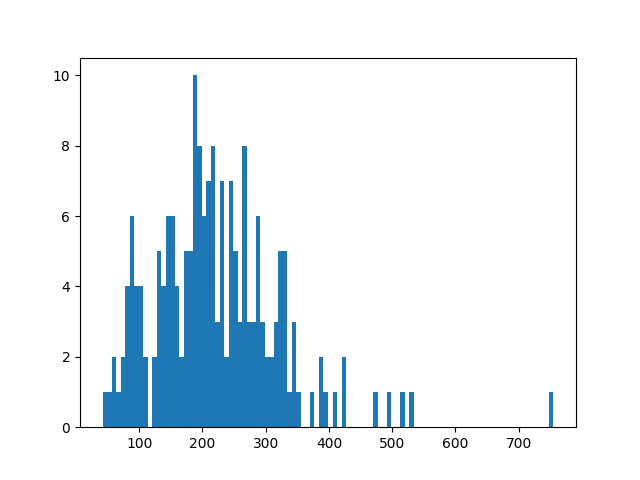

In [427]:
print(len(domain_circles))
plt.figure()
plt.hist([len(x) for x in domain_circles], bins=100)
plt.show()

253


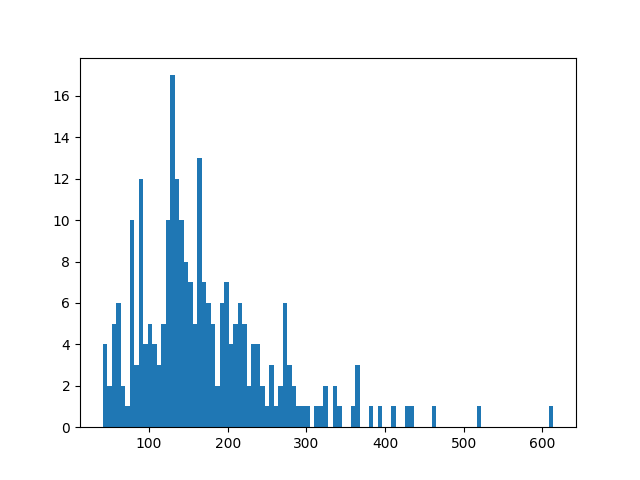

In [152]:
print(len(domain_circles))
plt.figure()
plt.hist([len(x) for x in domain_circles], bins=100)
plt.show()

### Visualize splitting

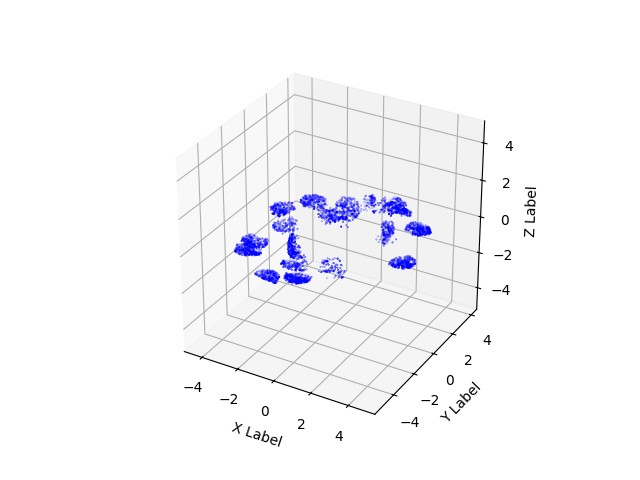

In [428]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    
# cmap = plt.get_cmap("Set1", max(kmeans.labels_))
# colors = cmap(kmeans.labels_)

    for idx, domain_circle_indcs in enumerate(domain_circles[8:100][::5]):
        arr_shape = domain[domain_circle_indcs].detach().cpu().numpy()
        ax.scatter(arr_shape[::kth,0], 
                   arr_shape[::kth,1], 
                   arr_shape[::kth,2], 
                   c='b', 
                   marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

### Fit style patches to those circles

In [429]:
from tqdm import tqdm_notebook as tqdm

def optimize_all_by_clusters(style_cluster_points, domain_points_cluster_list):
    target_points_cluster_list = []
    for domain_points_cluster in tqdm(domain_points_cluster_list):
        target_points_cluster = fit_target_to_domain(target_points=style_cluster_points, 
                                                     domain_points=domain_points_cluster)
        target_points_cluster_list.append(target_points_cluster)
    return target_points_cluster_list
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain
    
def fit_target_to_domain(target_points, domain_points, device="cuda", verbose=True):
    target_points_torch = torch.tensor(target_points, device=device)
    domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
    
    domain_std = torch.std(domain_points_torch, dim=0)
    domain_mean = torch.mean(domain_points_torch, dim=0)
    target_mean = torch.mean(target_points_torch, dim=0)
    target_std = torch.std(target_points_torch, dim=0)
    # Init random
    # points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device) * domain_std*3 + domain_mean ) 
    # Init with target points
    points_torch = torch.nn.Parameter(torch.tensor(target_points_torch, device=device) * domain_std*5. + domain_mean ) 
    
    # points_torch = torch.nn.Parameter(\
    #     torch.tensor((target_points_torch - target_mean) / target_std, device=device) * domain_std*5. + domain_mean  + \
    #     torch.randn_like(target_points_torch, device=device) * domain_std*5 + domain_mean\
    #     ) 
    
    #print(torch.std(domain_points_torch.detach(), dim=0))
    #print(torch.mean(domain_points_torch.detach(), dim=0))

    
    #print(domain_mean, domain_std)
    #points_torch = points_torch * domain_std * 2.  + domain_mean
    #print("points_torch.shape:", points_torch.shape) 
    # Compute nearest neighbors and target descriptors for both points and vecs
    num_nns = 2000
    kth_nn = 20
    num_nns_local = 100 # was 100
    kth_nn_local = 1
    distances = torch.cdist(target_points_torch, target_points_torch)
    _, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
    target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices[::kth_nn])
    #print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    # Now add even stronger local loss
    
    _, nns_indices_local = torch.topk(distances, k=num_nns_local, largest=False, dim=-1)
    target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
    #print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    
    optimizer = torch.optim.Adam([points_torch], lr=1e-3) # was 1e-3
    w_loss_local2 = 1e2 
  
    for iter in range(1001):
        if iter==10000:
            for g in optimizer.param_groups:
                g['lr'] = 1e-2
            w_loss_local2 = 1e3
            
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[::kth_nn])
        loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
        loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

        #loss = loss_points_local*5e0 + loss_points_local2*2e2 + loss_domain * 3e1 #+ loss_domain_coverage * 1e1
        loss = loss_points_local*1e0 + loss_points_local2*2e2 + loss_domain * 3e1 #+ loss_domain_coverage * 1e1
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iter % 1000 == 0 and verbose:
            print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")
    

    # for iter in range(1001):
    #     descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[::kth_nn])
    #     loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
    #     descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
    #     loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
    #     loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
        
    #     #loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2
    #     loss = loss_points_local*0e0 + loss_points_local2*5e1 + loss_domain * 0e1 #+ loss_domain_coverage * 1e1
        
    #     loss.backward()
    #     optimizer.step()
    #     optimizer.zero_grad()
    #     if iter % 100 == 0 and verbose:
    #         print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")

    return points_torch.detach()







### Test on a couple of clusters

In [430]:
! date
fitted_style_clusters_list = optimize_all_by_clusters(
    style_cluster_points=gaussians_xyz,  
    domain_points_cluster_list=[domain[domain_circle_indcs] 
                                for domain_circle_indcs in domain_circles[9:12]])
! date 

Wed Nov  8 13:08:42 PST 2023


/tmp/ipykernel_3866684/1140856219.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for domain_points_cluster in tqdm(domain_points_cluster_list):


  0%|          | 0/3 [00:00<?, ?it/s]

loss_points_local:0.0363076, loss_points_local2:0.0022407, loss_domain:0.0025390


/tmp/ipykernel_3866684/1140856219.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
/tmp/ipykernel_3866684/1140856219.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_torch = torch.nn.Parameter(torch.tensor(target_points_torch, device=device) * domain_std*5. + domain_mean )


loss_points_local:0.0203161, loss_points_local2:0.0001073, loss_domain:0.0013881
loss_points_local:0.0473789, loss_points_local2:0.0032151, loss_domain:0.0058937
loss_points_local:0.0227603, loss_points_local2:0.0001319, loss_domain:0.0028305
loss_points_local:0.0309653, loss_points_local2:0.0018574, loss_domain:0.0062428
loss_points_local:0.0251348, loss_points_local2:0.0001396, loss_domain:0.0025051
Wed Nov  8 13:08:51 PST 2023


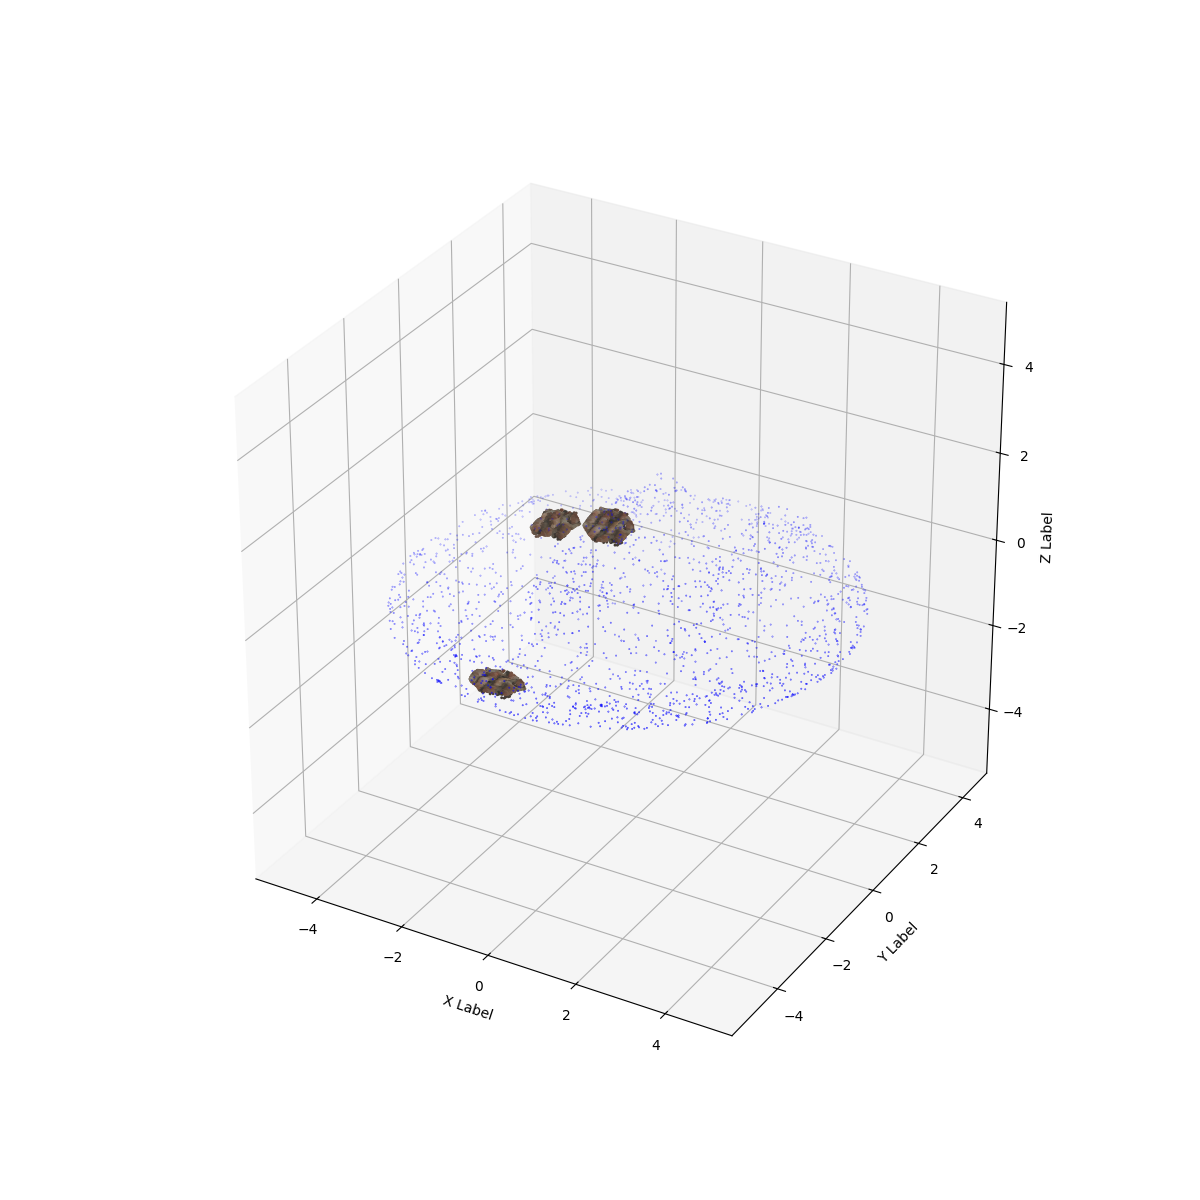

In [431]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=10
if True:
    arr_shape = domain.detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)


# # Plot optimized points
for fitted_style_cluster in fitted_style_clusters_list:
    arr = fitted_style_cluster.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes / 5., #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [432]:
! date
fitted_style_clusters_list = optimize_all_by_clusters(
    style_cluster_points=gaussians_xyz,  
    domain_points_cluster_list=[domain[domain_circle_indcs] 
                                for domain_circle_indcs in domain_circles[:]])
! date 

Wed Nov  8 13:09:04 PST 2023


/tmp/ipykernel_3866684/1140856219.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for domain_points_cluster in tqdm(domain_points_cluster_list):


  0%|          | 0/189 [00:00<?, ?it/s]

loss_points_local:0.0253725, loss_points_local2:0.0020294, loss_domain:0.0143973


/tmp/ipykernel_3866684/1140856219.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
/tmp/ipykernel_3866684/1140856219.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_torch = torch.nn.Parameter(torch.tensor(target_points_torch, device=device) * domain_std*5. + domain_mean )


loss_points_local:0.0149168, loss_points_local2:0.0001293, loss_domain:0.0051619
loss_points_local:0.0185679, loss_points_local2:0.0015112, loss_domain:0.0664397
loss_points_local:0.0341288, loss_points_local2:0.0003174, loss_domain:0.0214726
loss_points_local:0.0318320, loss_points_local2:0.0021335, loss_domain:0.0281480
loss_points_local:0.0210148, loss_points_local2:0.0001354, loss_domain:0.0084960
loss_points_local:0.0208823, loss_points_local2:0.0015851, loss_domain:0.0076780
loss_points_local:0.0232145, loss_points_local2:0.0001285, loss_domain:0.0023843
loss_points_local:0.0230910, loss_points_local2:0.0017968, loss_domain:0.0110715
loss_points_local:0.0181651, loss_points_local2:0.0001177, loss_domain:0.0035542
loss_points_local:0.0399299, loss_points_local2:0.0031225, loss_domain:0.0111473
loss_points_local:0.0221637, loss_points_local2:0.0001329, loss_domain:0.0040225
loss_points_local:0.0512815, loss_points_local2:0.0036315, loss_domain:0.0065057
loss_points_local:0.0235249,

In [403]:
for domain_circle_indcs in domain_circles[82:85]:
    print(len(domain_circle_indcs))

398
898
526


In [122]:
# ! date
# fitted_style_clusters_list = optimize_all_by_clusters(
#     style_cluster_points=gaussians_xyz,  
#     domain_points_cluster_list=[domain[domain_circle_indcs] 
#                                 for domain_circle_indcs in domain_circles[182:185]])
# ! date 

Tue Nov  7 23:06:42 PST 2023


/tmp/ipykernel_3866684/788589316.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for domain_points_cluster in tqdm(domain_points_cluster_list):


  0%|          | 0/3 [00:00<?, ?it/s]

loss_points_local:0.0014036, loss_points_local2:0.0000629, loss_domain:0.0042482


/tmp/ipykernel_3866684/788589316.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
/tmp/ipykernel_3866684/788589316.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_torch = torch.nn.Parameter(torch.tensor(target_points_torch, device=device) * domain_std*10. + domain_mean )


loss_points_local:0.0031843, loss_points_local2:0.0000255, loss_domain:0.0027052
loss_points_local:0.0010952, loss_points_local2:0.0000560, loss_domain:0.0073708
loss_points_local:0.0036067, loss_points_local2:0.0000292, loss_domain:0.0050838
loss_points_local:0.0014575, loss_points_local2:0.0000653, loss_domain:0.0115773
loss_points_local:0.0041296, loss_points_local2:0.0000336, loss_domain:0.0084988
Tue Nov  7 23:06:49 PST 2023


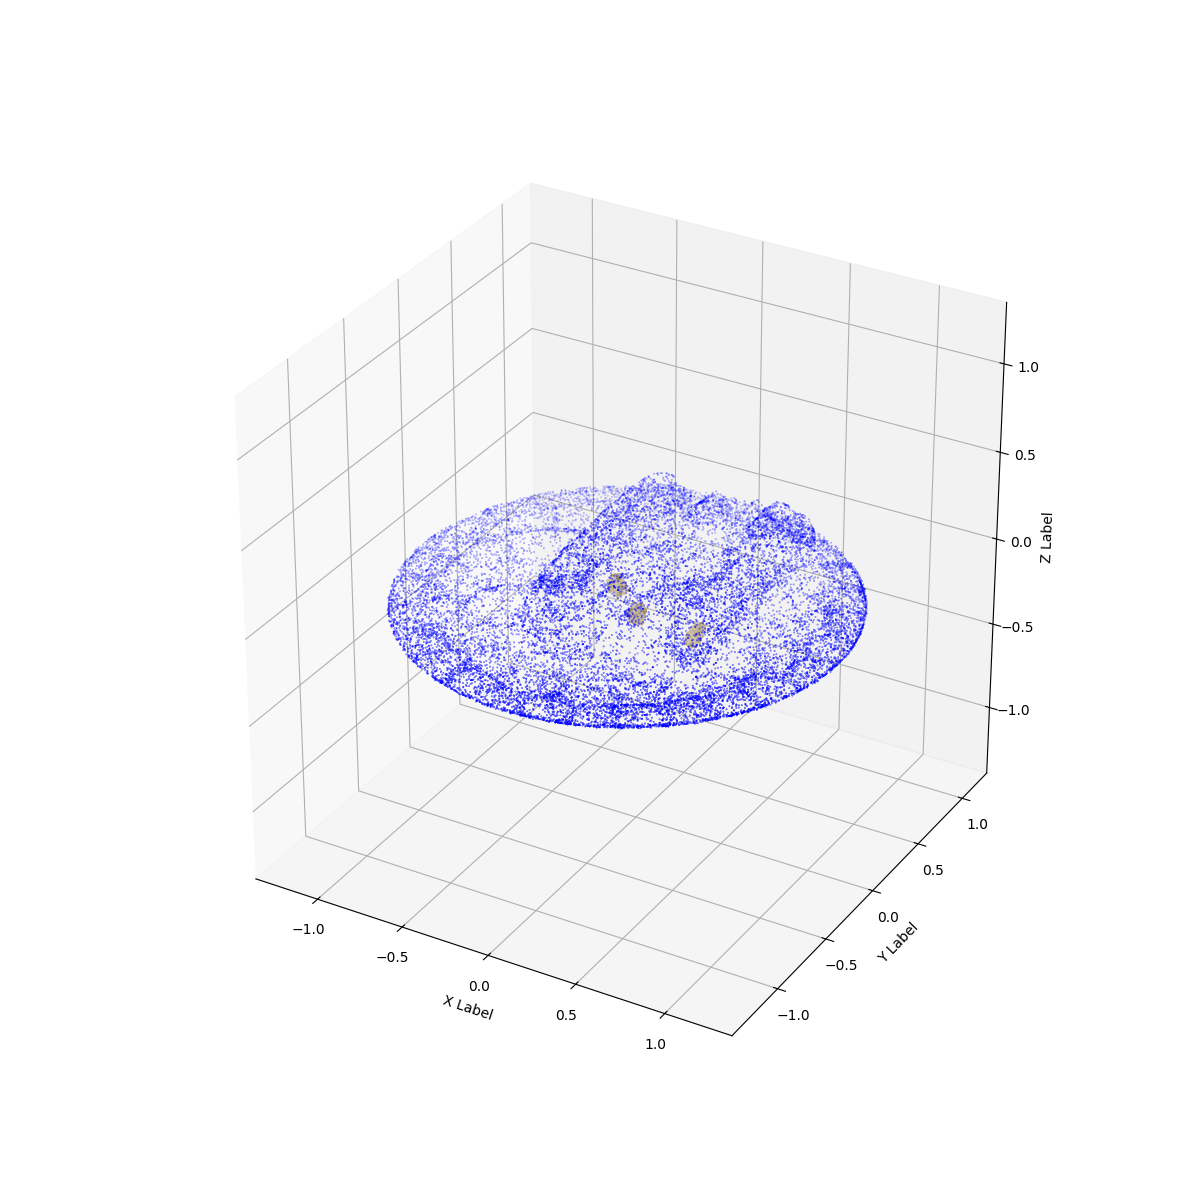

In [124]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
if True:
    arr_shape = domain.detach().cpu().numpy()
    ax.scatter(arr_shape[:,0], 
               arr_shape[:,1], 
               arr_shape[:,2], c='b', marker='o',s=0.1)


# # Plot optimized points
for fitted_style_cluster in fitted_style_clusters_list:
    arr = fitted_style_cluster.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes / 5., #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [433]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
#gaussians_to_save.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)


# Store optimized parameters to the gaussias_to_save
N = len(fitted_style_clusters_list)
gaussians_to_save._xyz = torch.tensor(torch.concat(fitted_style_clusters_list, dim=0).clone().detach())
# gaussians_to_save._xyz = torch.tensor(target_points_torch).clone().detach()
gaussians_to_save._rotation = torch.tensor(np.concatenate([gaussians_rotation]*N, axis=0))
gaussians_to_save._features_dc = torch.tensor(np.concatenate([gaussians_features_dc]*N, axis=0))
gaussians_to_save._features_rest = torch.tensor(np.concatenate([gaussians_features_rest*0.]*N, axis=0))
gaussians_to_save._scaling = torch.tensor(np.concatenate([gaussians_scaling*0.885]*N, axis=0)) #was 0.885
gaussians_to_save._opacity = torch.tensor(np.concatenate([gaussians_opacity]*N, axis=0))


iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))



/tmp/ipykernel_3866684/629224335.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(torch.concat(fitted_style_clusters_list, dim=0).clone().detach())


## Save without overlaps

In [405]:

def find_overlapping_gaussians(domain, points_list, eps=1e-2):
    # Find centers of every cluster listed in the points_list
    centroids_list = torch.stack([torch.mean(points, dim=0) for points in points_list], axis=0)
    print("1:")
    print(centroids_list)
    # For each domain point find the nearest cluster index from the points_list
    domain_to_centroid_idx = torch.argmin(torch.torch.cdist(domain, centroids_list), dim=-1)
    print("2:")
    print(domain_to_centroid_idx)
    # now compute distance from every point from each cluster from the points_list to the nearest domain points index
    
    points_list_to_domain = []
    for points in points_list:
        
        points_to_domain = torch.argmin(torch.torch.cdist(points, domain), dim=-1)
        points_list_to_domain.append(points_to_domain)
    print("3:")
    print(points_list_to_domain)
    # Find indices of points from each element of the points_list to retain. 
    points_list_idcs_to_retain = []
    for points_idx, points_to_domain in enumerate(points_list_to_domain):
        print("points_to_domain[domain_to_centroid_idx]:")
        print(points_to_domain[domain_to_centroid_idx])
        idcs_to_retain = torch.where(domain_to_centroid_idx[points_to_domain] == points_idx)[0]
        print("idcs_to_retain:",idcs_to_retain)
        points_list_idcs_to_retain.append(idcs_to_retain)

    return points_list_idcs_to_retain

points_torch_list=fitted_style_clusters_list
domain_points_torch=torch.tensor(domain, device="cuda")
points_torch_list_idcs_to_retain = find_overlapping_gaussians(domain=domain_points_torch, 
                                                              points_list=points_torch_list)

/tmp/ipykernel_3866684/1844792108.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch=torch.tensor(domain, device="cuda")


1:
tensor([[-1.9610,  1.9149, -2.4988],
        [-1.9955,  1.9830, -1.9767],
        [-0.4762, -0.2530, -0.2221],
        [ 0.1688, -0.6130, -0.2235],
        [ 0.1456,  0.2530, -0.2536],
        [ 0.9100,  2.5525,  3.4874],
        [-1.9393,  1.9329,  0.9886],
        [-2.1116,  1.4739,  1.1607],
        [-1.5811,  2.1056,  1.7338],
        [-1.5108,  1.9822,  1.0121],
        [-2.3237, -0.5176, -0.2099],
        [-2.5172, -1.3400, -0.7385],
        [-1.8603, -1.0321, -0.4191],
        [-2.4432, -0.2680, -0.4542],
        [-1.9265, -0.3980, -0.3456],
        [ 1.3545,  1.8040, -0.5634],
        [ 1.7388,  1.3718, -0.7548],
        [ 1.6652,  1.9315, -0.1071],
        [ 2.0628, -0.4353, -0.1236],
        [ 2.3667, -0.5591, -0.7071],
        [ 2.1457, -0.9057, -0.4876],
        [ 1.5633, -0.9646, -0.4277],
        [ 0.4063, -2.4482, -1.6308],
        [-0.1183, -2.6184, -1.1405],
        [ 0.3744, -2.4910, -0.7754],
        [-1.7616,  1.9336, -0.0402],
        [-1.9798,  1.2999, -0.7291]

In [437]:

import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)


# Store optimized parameters to the gaussias_to_save
N = len(points_torch_list)
idcs_to_retain_list = [idcs.detach().cpu().numpy() for idcs in points_torch_list_idcs_to_retain]
gaussians_xyz_ = [points[idcs] for points, idcs in zip(points_torch_list, points_torch_list_idcs_to_retain)]
gaussians_to_save._xyz = torch.tensor(torch.concat(gaussians_xyz_, dim=0).clone().detach())
gaussians_rotation_ = [gaussians_rotation[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._rotation = torch.tensor(np.concatenate(gaussians_rotation_, axis=0))
gaussians_features_dc_ = [gaussians_features_dc[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._features_dc = torch.tensor(np.concatenate(gaussians_features_dc_, axis=0))
gaussians_features_rest_ = [gaussians_features_rest[idcs]*0. for idcs in idcs_to_retain_list]
gaussians_to_save._features_rest = torch.tensor(np.concatenate(gaussians_features_rest_, axis=0))
gaussians_scaling_ = [gaussians_scaling[idcs]*0.885 for idcs in idcs_to_retain_list]
gaussians_to_save._scaling = torch.tensor(np.concatenate(gaussians_scaling_, axis=0)) #was 0.885
gaussians_opacity_ = [gaussians_opacity[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._opacity = torch.tensor(np.concatenate(gaussians_opacity_, axis=0))
print(gaussians_to_save._xyz.shape, 
      gaussians_to_save._rotation.shape,
      gaussians_to_save._features_dc.shape,
      gaussians_to_save._features_rest.shape,
      gaussians_to_save._scaling.shape,
      gaussians_to_save._opacity.shape,
     )

gaussians_to_save._xyz = gaussians_to_save._xyz * 0.4
gaussians_to_save._scaling = gaussians_to_save._scaling * 1.1
iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))

/tmp/ipykernel_3866684/849736999.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(torch.concat(gaussians_xyz_, dim=0).clone().detach())


torch.Size([378926, 3]) torch.Size([378926, 4]) torch.Size([378926, 1, 3]) torch.Size([378926, 15, 3]) torch.Size([378926, 3]) torch.Size([378926, 1])


# Render image and depth.

In [487]:
from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint

In [465]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)


_StoreAction(option_strings=['--start_checkpoint'], dest='start_checkpoint', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [482]:
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/chair/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)

In [483]:
dataset=lp.extract(args)
pipe=pp.extract(args)

In [484]:
args.source_path

'/home/dimakot55/data/nerf_synthetic/chair/'

In [485]:
scene = Scene(dataset, gaussians_to_save, shuffle=True)

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


NameError: name 'randint' is not defined

In [502]:
N = len(points_torch_list)
idcs_to_retain_list = [idcs.detach().cpu().numpy() for idcs in points_torch_list_idcs_to_retain]
gaussians_xyz_ = [points[idcs] for points, idcs in zip(points_torch_list, points_torch_list_idcs_to_retain)]
gaussians_to_save._xyz = torch.tensor(torch.concat(gaussians_xyz_, dim=0).clone().detach())
gaussians_rotation_ = [gaussians_rotation[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._rotation = torch.tensor(np.concatenate(gaussians_rotation_, axis=0))
gaussians_features_dc_ = [gaussians_features_dc[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._features_dc = torch.tensor(np.concatenate(gaussians_features_dc_, axis=0))
gaussians_features_rest_ = [gaussians_features_rest[idcs]*0. for idcs in idcs_to_retain_list]
gaussians_to_save._features_rest = torch.tensor(np.concatenate(gaussians_features_rest_, axis=0))
gaussians_scaling_ = [gaussians_scaling[idcs]*0.885 for idcs in idcs_to_retain_list]
gaussians_to_save._scaling = torch.tensor(np.concatenate(gaussians_scaling_, axis=0)) #was 0.885
gaussians_opacity_ = [gaussians_opacity[idcs] for idcs in idcs_to_retain_list]
gaussians_to_save._opacity = torch.tensor(np.concatenate(gaussians_opacity_, axis=0))
print(gaussians_to_save._xyz.shape, 
      gaussians_to_save._rotation.shape,
      gaussians_to_save._features_dc.shape,
      gaussians_to_save._features_rest.shape,
      gaussians_to_save._scaling.shape,
      gaussians_to_save._opacity.shape,
     )

gaussians_to_save._xyz = gaussians_to_save._xyz * 0.4
gaussians_to_save._scaling = gaussians_to_save._scaling * 1.1

torch.Size([378926, 3]) torch.Size([378926, 4]) torch.Size([378926, 1, 3]) torch.Size([378926, 15, 3]) torch.Size([378926, 3]) torch.Size([378926, 1])


/tmp/ipykernel_3866684/2411330807.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(torch.concat(gaussians_xyz_, dim=0).clone().detach())


In [503]:
viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

render_pkg = render(viewpoint_cam, gaussians_to_save, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii, depth= render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["depth"]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [500]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)

# Clip values to be in the range [0, 1]
#image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

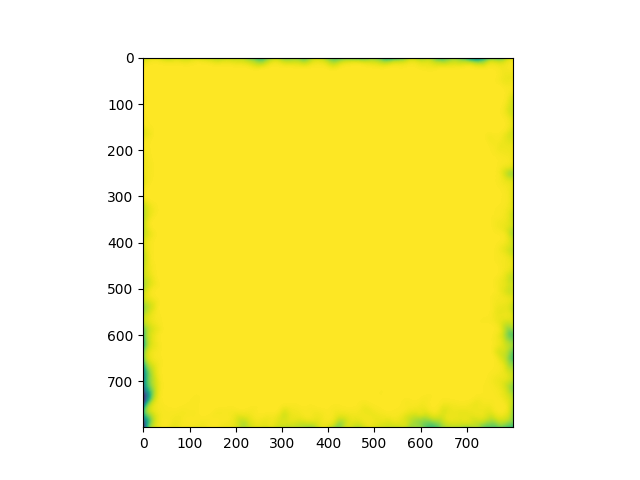

In [501]:
plt.imshow(image_rgb[...,0])
plt.show()

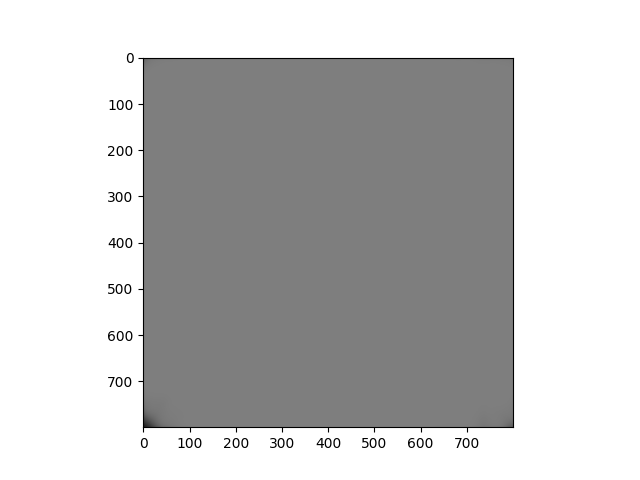

In [494]:

plt.figure()
plt.imshow(image_rgb)
plt.show()